# Dataset - Bank Marketing
The [data](https://archive.ics.uci.edu/dataset/222/bank+marketing) is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';',na_values='unknown')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# EDA

## Input variables

### Bank Client Data
1. `age` (numeric)
2. `job` : type of job (categorical)
3. `marital` : marital status (categorical)
4. `education` (categorical)
5. `default`: has credit in default? (categorical)
6. `housing`: has housing loan? (categorical)
7. `loan`: has personal loan? (categorical)

### Related With The Last Contact Of The Current Campaign
8. `contact`: contact communication type (categorical) 
9. `month`: last contact month of year (categorical)
10.  `day_of_week`: last contact day of the week (categorical)
11.  `duration`: last contact duration, in seconds (numeric).

### Other attributes
12. `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. `previous`: number of contacts performed before this campaign and for this client (numeric)
15. `poutcome`: outcome of the previous marketing campaign (categorical)

### Social And Economic Context Attributes
16. `emp.var.rate`: employment variation rate - quarterly indicator (numeric)
17. `cons.price.idx`: consumer price index - monthly indicator (numeric)     
18. `cons.conf.idx`: consumer confidence index - monthly indicator (numeric)     
19. `euribor3m`: euribor 3 month rate - daily indicator (numeric)
20. `nr.employed`: number of employees - quarterly indicator (numeric)

### Output variable (desired target)
21. `y` - has the client subscribed a term deposit? (binary: "yes","no")

In [3]:
print(df.shape)
print()
print(df.info())

(41188, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41

In [4]:
# For numerical columns
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [5]:
# For categorical columns
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,40858,41108,39457,32591,40198,40198,41188,41188,41188,41188,41188
unique,11,3,7,2,2,2,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [6]:
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    print(f"Column: {col}")
    print(df[col].value_counts(dropna=False))
    print()

Column: job
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
NaN                330
Name: count, dtype: int64

Column: marital
marital
married     24928
single      11568
divorced     4612
NaN            80
Name: count, dtype: int64

Column: education
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
NaN                     1731
illiterate                18
Name: count, dtype: int64

Column: default
default
no     32588
NaN     8597
yes        3
Name: count, dtype: int64

Column: housing
housing
yes    21576
no     18622
NaN      990
Name: count, dtype: int64

Column: loan
loan
no     33950
yes     6248
NaN      990
Name: count, dtype: int64

Column:

### Removing Noise
I will delete `yes` option from `default` and `illiterate` from `education` as they don't give enough value and introduce noise.

In [7]:
df = df[df['education'] != 'illiterate']
df = df[df['default'] != 'yes']

### Duplicates
I will drop rows that are a duplicates of each others since they do not provide value for modeling.

In [8]:
df.drop_duplicates(inplace=True)
print(df.shape)

(41155, 21)


### `NaN`
Based on percentages - we can drop `NaN` from every column besides `default`. We are loosing about 7% from big dataset so it should be OK.

In [9]:
# How many NaN in each column - percentage
nan_percentage = df.isna().mean() * 100
print(nan_percentage[nan_percentage > 0])

job           0.801847
marital       0.194387
education     4.203620
default      20.869882
housing       2.405540
loan          2.405540
dtype: float64


In [10]:
# Drop nan from 'job' and 'marital' columns
df.dropna(subset=['job', 'marital','education','housing','loan'], inplace=True)
print(df.shape)

(38213, 21)


We go back to having NaN in default as a category

In [11]:
df.fillna({'default':'unknown'}, inplace=True)
print("\nWartości w kolumnie 'default' po zamianie NaN:")
print(df['default'].value_counts(dropna=False))


Wartości w kolumnie 'default' po zamianie NaN:
default
no         30464
unknown     7749
Name: count, dtype: int64


In [12]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### `pdays`
Value of 999 means that there has been no contact with the client beforehand (in a previous campaign). Thus it makes sense to create a new binary column saying if there was a contact or not.

In [13]:
# Create a new column based on pdays column if there was a contact with the customer in previous campaign (every option besides 999) or not (999)
df['pdays_contact'] = df['pdays'].apply(lambda x: 1 if x != 999 else 0)
# Drop pdays column
df.drop(columns=['pdays'], inplace=True)

# Convert 'contacted' column to categorical
df['pdays_contact'] = df['pdays_contact'].astype('category')

In [14]:
# Mapping y to 1 and 0
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38213 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             38213 non-null  int64   
 1   job             38213 non-null  object  
 2   marital         38213 non-null  object  
 3   education       38213 non-null  object  
 4   default         38213 non-null  object  
 5   housing         38213 non-null  object  
 6   loan            38213 non-null  object  
 7   contact         38213 non-null  object  
 8   month           38213 non-null  object  
 9   day_of_week     38213 non-null  object  
 10  duration        38213 non-null  int64   
 11  campaign        38213 non-null  int64   
 12  previous        38213 non-null  int64   
 13  poutcome        38213 non-null  object  
 14  emp.var.rate    38213 non-null  float64 
 15  cons.price.idx  38213 non-null  float64 
 16  cons.conf.idx   38213 non-null  float64 
 17  euribor3m       3

### `Duration`
The `duration` is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, it should be discarded if the intention is to have a realistic predictive model.

In [16]:
# Drop the 'duration' column
df.drop(columns=['duration'], inplace=True)
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,0


### Subscription rate
I check subscription rate to evaluate how strongly the category is connected to the getting a client to deposit. Based on the rate we can aggregate categories together.

In [17]:
categorical_features_to_analyze = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 
    'contact', 'month', 'day_of_week', 'poutcome', 'contacted'
]
numerical_features_to_analyze = [
    'age', 'campaign', 'previous', 'emp.var.rate', 
    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
]

# Categorical features vs target variable 'y'
for col in categorical_features_to_analyze:
    if col in df.columns:
        print(f"\n--- Impact of '{col}' for 'y' ---")
        
        # Group by category and calculate the mean of 'y' (percentage of 'yes')
        # and the number of observations in each category
        impact_df = df.groupby(col, observed=False)['y'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
        impact_df.rename(columns={'mean': 'subscription_rate', 'count': 'observations'}, inplace=True)
        
        print(impact_df)


--- Impact of 'job' for 'y' ---
               subscription_rate  observations
job                                           
student                 0.302326           688
retired                 0.246662          1573
unemployed              0.143451           962
admin.                  0.129065          9933
management              0.111437          2728
self-employed           0.107727          1346
technician              0.107154          6374
housemaid               0.099391           986
entrepreneur            0.084683          1358
services                0.079968          3714
blue-collar             0.069583          8551

--- Impact of 'marital' for 'y' ---
          subscription_rate  observations
marital                                  
single             0.136588         10755
divorced           0.103978          4299
married            0.100911         23159

--- Impact of 'education' for 'y' ---
                     subscription_rate  observations
education        

### Aggregation
Based on the values of `subscription_rate`:
- `education` -> combine `basic.4y`, `basic.6y`, `basic.9y` into one category called `basic_education`
- `marital` -> combine `divorced` and `married` into `married_or_divorced`
- `month` -> combine months based on the conversion rate

In [18]:
# Aggregate data from education column - categories 'basic.4y', 'basic.6y', 'basic.9y' to 'basic_education'
df['education'] = df['education'].replace({
    'basic.4y': 'basic_education', 
    'basic.6y': 'basic_education', 
    'basic.9y': 'basic_education'
})

In [20]:
# # Wizualizacja (opcjonalnie, ale bardzo pomocne)
# if len(impact_df) > 1 and len(impact_df) < 35: # Ograniczenie dla czytelności wykresu
#     plt.figure(figsize=(10, 6))
#     # Zastosowanie sugestii z warningu:
#     sns.barplot(
#         x=impact_df.index.astype(str), 
#         y='subscription_rate', 
#         data=impact_df.reset_index(), 
#         hue=impact_df.index.astype(str), # Przypisz to samo co x do hue
#         palette="viridis",
#         legend=False # Wyłącz legendę, bo etykiety są na osi X
#     )
#     plt.title(f'Subscription Rate by {col}', fontsize=15)
#     plt.ylabel('Subscription Rate (Fraction of "yes")', fontsize=12)
#     plt.xlabel(col, fontsize=12)
#     plt.xticks(rotation=45, ha="right", fontsize=10)
#     plt.yticks(fontsize=10)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.tight_layout()
#     plt.show()
# elif len(impact_df) >= 35:
#             print(f"INFO: Pomijanie wykresu dla '{col}' z powodu dużej liczby kategorii ({len(impact_df)}).")

In [21]:
# print("\n" + "="*30 + " Analiza Zmiennych Numerycznych " + "="*30)
# for col in numerical_features_to_analyze:
#     if col in df.columns:
#         print(f"\n--- Wpływ zmiennej '{col}' na 'y' ---")
        
#         # a) Wykresy pudełkowe (Box Plots)
#         plt.figure(figsize=(8, 6))
#         sns.boxplot(x='y', y=col, data=df, hue='y', palette="coolwarm", legend=False)
#         plt.title(f'Distribution of {col} by Subscription Status (y)', fontsize=15)
#         plt.xlabel('Subscribed (0 = No, 1 = Yes)', fontsize=12)
#         plt.ylabel(col, fontsize=12)
#         plt.xticks(fontsize=10)
#         plt.yticks(fontsize=10)
#         plt.grid(axis='y', linestyle='--', alpha=0.7)
#         plt.show()

#         # b) Histogramy/Wykresy Gęstości nałożone na siebie
#         plt.figure(figsize=(10, 6))
#         sns.histplot(data=df, x=col, hue='y', kde=True, stat="density", common_norm=False, palette="coolwarm")
#         plt.title(f'Distribution of {col} by Subscription Status (y)', fontsize=15)
#         plt.xlabel(col, fontsize=12)
#         plt.ylabel('Density', fontsize=12)
#         plt.xticks(fontsize=10)
#         plt.yticks(fontsize=10)
#         plt.legend(title='Subscribed', labels=['Yes (1)', 'No (0)']) # Kolejność etykiet może zależeć od palety i danych
#         plt.grid(axis='y', linestyle='--', alpha=0.7)
#         plt.show()
        
#     else:
#         print(f"OSTRZEŻENIE: Kolumna '{col}' nie znaleziona w DataFrame.")

### Checking corelation

y                 1.000000
previous          0.221248
cons.conf.idx     0.051235
age               0.029902
campaign         -0.065110
cons.price.idx   -0.132668
emp.var.rate     -0.292015
euribor3m        -0.300402
nr.employed      -0.347757
Name: y, dtype: float64


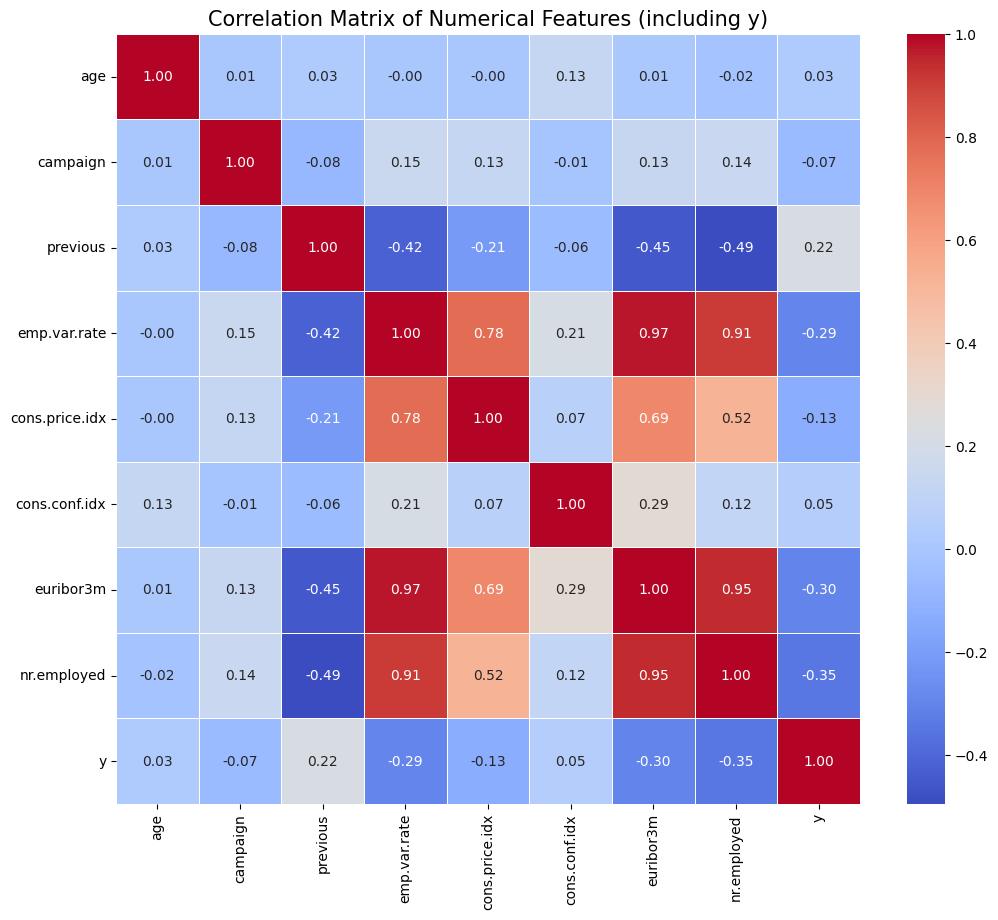

In [22]:
# Corelation of numerical features with target variable 'y'
# We choose only numerical columns and the target variable 'y'
numerical_and_target_for_corr = numerical_features_to_analyze + ['y']

# Usuwamy kolumny, które mogłyby nie istnieć (np. 'duration' jeśli ją usunąłeś)
existing_cols_for_corr = [col for col in numerical_and_target_for_corr if col in df.columns]

df_subset_for_corr = df[existing_cols_for_corr].copy()

correlation_with_target = df_subset_for_corr.corr()['y'].sort_values(ascending=False)
print(correlation_with_target)

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_subset_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features (including y)', fontsize=15)
plt.show()


============================== Pairplot dla Wybranych Zmiennych Numerycznych ==============================
Generowanie pairplot dla: ['age', 'campaign'] z hue='y'


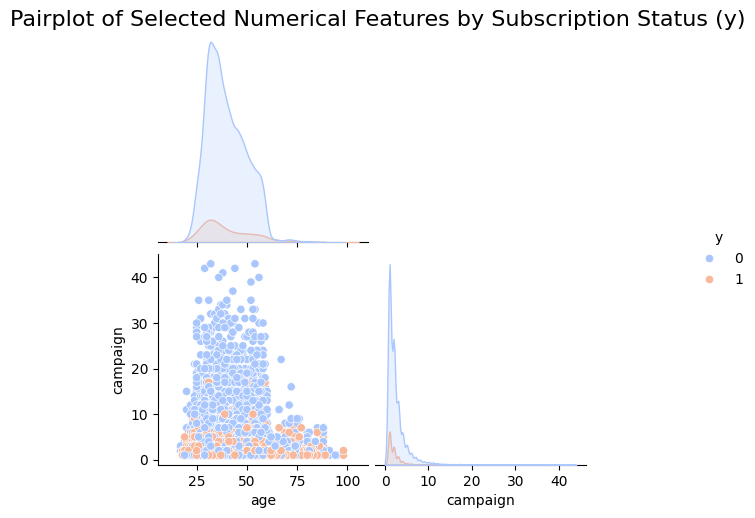


Analiza wpływu cech na 'y' zakończona.


In [23]:
# --- KROK 1.3: Pairplot dla wybranych zmiennych numerycznych ---
# (Opcjonalnie, wybierz kilka najważniejszych lub najbardziej interesujących zmiennych numerycznych)
print("\n" + "="*30 + " Pairplot dla Wybranych Zmiennych Numerycznych " + "="*30)
# Wybierz podzbiór zmiennych numerycznych do pairplotu
# np. ['age', 'duration', 'campaign', 'previous']
selected_numerical_for_pairplot = ['age', 'duration', 'campaign'] # Dostosuj tę listę!
# Upewnij się, że wybrane kolumny istnieją i dodaj 'y'
pairplot_cols = [col for col in selected_numerical_for_pairplot if col in df.columns]
if 'y' in df.columns and pairplot_cols: # Sprawdź, czy 'y' i lista kolumn nie są puste
    pairplot_cols_with_y = pairplot_cols + ['y']
    
    # Sprawdzenie, czy nie ma NaN w tym podzbiorze
    df_pairplot_subset = df[pairplot_cols_with_y].copy()
    if df_pairplot_subset.isnull().sum().any():
        print(f"OSTRZEŻENIE: Wykryto NaN w danych dla pairplot ({pairplot_cols_with_y}). Rozważ usunięcie NaN lub imputację przed pairplot.")
        # df_pairplot_subset.dropna(inplace=True) # Jeśli chcesz usunąć

    if not df_pairplot_subset.empty:
        print(f"Generowanie pairplot dla: {pairplot_cols} z hue='y'")
        sns.pairplot(df_pairplot_subset, hue='y', palette="coolwarm", diag_kind='kde', corner=True)
        plt.suptitle('Pairplot of Selected Numerical Features by Subscription Status (y)', y=1.02, fontsize=16)
        plt.show()
    else:
        print("Nie można wygenerować pairplot - podzbiór danych jest pusty.")
else:
    print("Nie można wygenerować pairplot - brak kolumny 'y' lub nie wybrano kolumn numerycznych.")

print("\nAnaliza wpływu cech na 'y' zakończona.")